# **CNN Image Classification**

In this exercise, we will classify images with different kinds of CNNs and different learning algorithms. Then we will compare the classification performance attained with the different variants.

Load the libraries, set the graphics to be plotted within the Jupyter notebook and fix the random seed to ensure the reproducibility of the results

In [1]:
%matplotlib inline
import os
import time
import datetime
import collections

from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

## **Data**

Establish the 10 classes that are available in the CIFAR10 dataset, see https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
class_names = ['airplane','automobile','bird','cat','deer', 
               'dog','frog','horse','ship','truck']

Download the training data for the CIFAR10 dataset, upzip it to the virtual 
folder ../data-unversioned/p1ch6/ and store it as the `cifar10` variable

In [3]:
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.4915, 0.4823, 0.4468),
                              (0.2470, 0.2435, 0.2616))]
                              )
    )

Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


Download the validation data for the CIFAR10 dataset, upzip it to the virtual 
folder ../data-unversioned/p1ch6/ and store it as the `cifar10_val` variable

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.4915, 0.4823, 0.4468),
                              (0.2470, 0.2435, 0.2616))]
                              )
    )

Files already downloaded and verified


Select the classes that the CNN will classify, namely the **cat** (index 3), the **dog** (index 5) and **horse** (index 7) classes

Then extract a subset of the full training CIFAR10 dataset which contains the training samples of those three classes into the `cifar3` variable, and a subset of the full validation CIFAR10 dataset with the validation samples of these three classes into the `cifar3_val` variable

In [5]:
# classes we are going to use
class_names = ['cat', 'dog', 'horse']
# map from old labels to new labels
label_map = {3: 0, 5: 1, 7: 2}
# get only the classes we want and relabel them
cifar3 = [(img, label_map[label]) for img, label in cifar10 if label in label_map]
cifar3_val = [(img, label_map[label]) for img, label in cifar10_val if label in label_map]

Now lets see some examples of the subset we just created.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


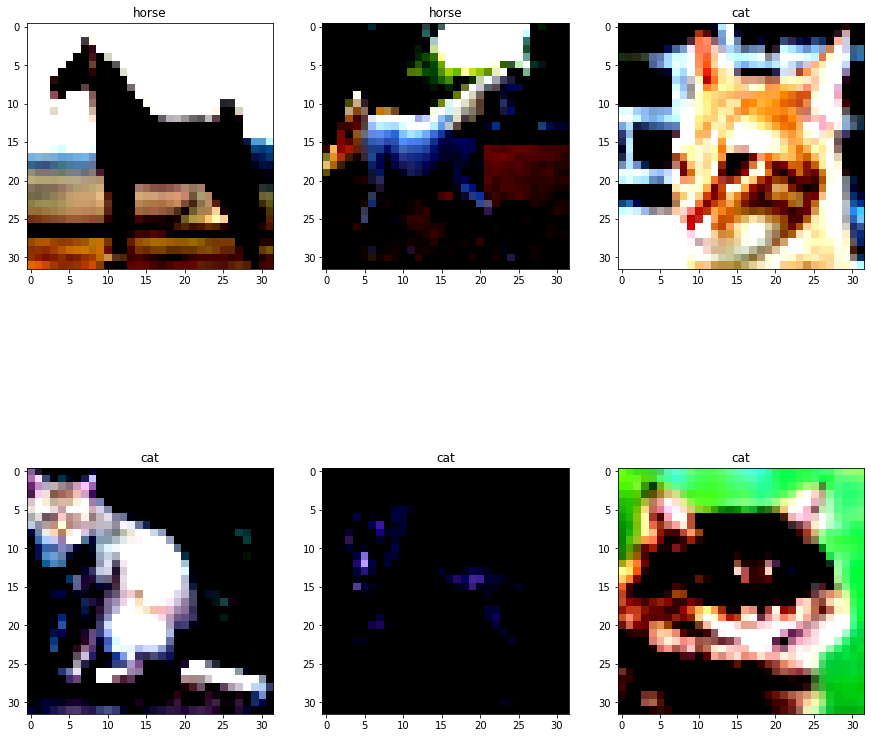

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
for i in range(6):
  sample = cifar3[np.random.randint(len(cifar3))]
  axs[int(i/3), i%3].imshow(np.transpose(sample[0].numpy(),(1, 2, 0)))
  axs[int(i/3), i%3].set_title(class_names[sample[1]])

Let's make sure the clases are balanced, if they are not we could use techniques like data augmentation to balance the dataset.

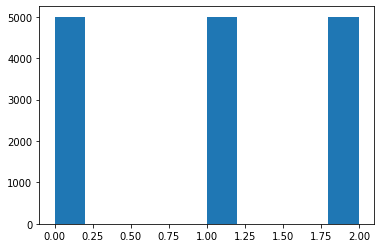

In [7]:
classes = [s[1] for s in cifar3]
plt.hist(classes)
plt.show()

They are perfectly balanced.

From the plot before I am a bit worried about the data, `Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).` appeared for every image, that means the range in the data is not between 0-1 or 0-255 which are the standard for images. Let's have a look...

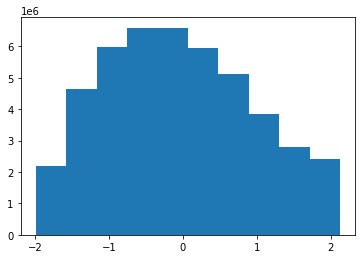

In [8]:
aggregated = [s[0].flatten().numpy() for s in cifar3]
plt.hist(np.array(aggregated).ravel())
plt.show()

For me it looks a bit strange that the range of data in images goes from -2 to more than 2. The explanation I can think of is the normallization of the data.

Finally we are going to create the data loaders that will help us in the training phase. The difference between the training loader and the calidation one, apart from the data they contain, is that the validation one should not be shuffled.

In [9]:
train_loader = torch.utils.data.DataLoader(cifar3, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar3_val, batch_size=64, shuffle=False)

## **Models Architectures**

In this section we are going to define the architecture of the different models.


### **Baseline**

We are going to start with a baseline that we will improve later on.

In [10]:
class NetBaseline(nn.Module):
  def __init__(self):
    super().__init__()
    # depth 3->24 same size(kernel_size=3, padding=1)
    self.conv1 = nn.Conv2d(3, 24, kernel_size=3, padding=1)
    # depth 24->8 same size(kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(24, 8, kernel_size=3, padding=1)
    # 8*8*8 -> 32
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    # 32 -> 3 (number of classes to classify)
    self.fc2 = nn.Linear(32, 3)
        
  def forward(self, x):
    # shape = (3, 32, 32)
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    # shape = (24, 16, 16)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    # shape = (8, 8, 8)
    out = out.view(-1, 8 * 8 * 8)
    # shape = (512)
    out = torch.tanh(self.fc1(out))
    # shape = (32)
    out = self.fc2(out)
    # shape = (3)
    return out

This `NetBaseline` model has 2 convolutional layers followed by hyperbolic tangent and max-pool layers. At the end it has a classfier made from 2 fully connected layers.

### **Width**

This model is very similar to the previous one, the only difference is the two fully connected layers at the end.

In [11]:
class NetWidth(nn.Module):
  def __init__(self):
    super().__init__()
    # depth 3->24 same size(kernel_size=3, padding=1)
    self.conv1 = nn.Conv2d(3, 24, kernel_size=3, padding=1)
    # depth 24->8 same size(kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(24, 8, kernel_size=3, padding=1)
    # 8*8*8 -> 40
    self.fc1 = nn.Linear(8 * 8 * 8, 40)
    # 40 -> 3 (number of classes to classify)
    self.fc2 = nn.Linear(40, 3)
        
  def forward(self, x):
    # shape = (3, 32, 32)
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    # shape = (24, 16, 16)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    # shape = (8, 8, 8)
    out = out.view(-1, 8 * 8 * 8)
    # shape = (512)
    out = torch.tanh(self.fc1(out))
    # shape = (40)
    out = self.fc2(out)
    # shape = (3)
    return out

### **Dropout**

This model adds dropout layers. These layers drop randomly connections during the training (it makes them zeros), this prevents neurons from speciallicing themselves in a part of the image. The output from that is a network more robuts that is able to generalize better.

In [12]:
class NetDropout(nn.Module):
  def __init__(self):
    super().__init__()
    # depth 3->24 same size(kernel_size=3, padding=1)
    self.conv1 = nn.Conv2d(3, 24, kernel_size=3, padding=1)
    self.dropout1 = nn.Dropout2d(p=0.6)
    # depth 24->8 same size(kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(24, 8, kernel_size=3, padding=1)
    self.dropout2 = nn.Dropout2d(p=0.6)
    # 8*8*8 -> 32
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    # 32 -> 3 (number of classes to classify)
    self.fc2 = nn.Linear(32, 3)
        
  def forward(self, x):
    # shape = (3, 32, 32)
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    # shape = (24, 16, 16)
    out = self.dropout1(out)
    # shape = (24, 16, 16)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    # shape = (8, 8, 8)
    out = self.dropout2(out)
    # shape = (8, 8, 8)
    out = out.view(-1, 8 * 8 * 8)
    # shape = (512)
    out = torch.tanh(self.fc1(out))
    # shape = (32)
    out = self.fc2(out)
    # shape = (3)
    return out

### **Batch Normalization**

This model normalize the whole batch after every convolution. It is not clear why it does help, but what it is clear is that it does it and it improves the training of the deep neural network.

In [13]:
class NetBatchNorm(nn.Module):
  def __init__(self):
    super().__init__()
    # depth 3->24 same size(kernel_size=3, padding=1)
    self.conv1 = nn.Conv2d(3, 24, kernel_size=3, padding=1)
    self.batchnorm1 = nn.BatchNorm2d(24)
    # depth 24->8 same size(kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(24, 8, kernel_size=3, padding=1)
    self.batchnorm2 = nn.BatchNorm2d(8)
    # 8*8*8 -> 40
    self.fc1 = nn.Linear(8 * 8 * 8, 40)
    # 40 -> 3 (number of classes to classify)
    self.fc2 = nn.Linear(40, 3)
        
  def forward(self, x):
    # shape = (3, 32, 32)
    out = F.max_pool2d(torch.tanh(self.batchnorm1(self.conv1(x))), 2)
    # shape = (24, 16, 16)
    out = F.max_pool2d(torch.tanh(self.batchnorm2(self.conv2(out))), 2)
    # shape = (8, 8, 8)
    out = out.view(-1, 8 * 8 * 8)
    # shape = (512)
    out = torch.tanh(self.fc1(out))
    # shape = (40)
    out = self.fc2(out)
    # shape = (3)
    return out

### **Depth**

Here we are adding one more convolutional layer. It seems that for deeper networks relu works better as activation function than hiperbolic tangent, so we are changing this here as well.

In [14]:
class NetDepth(nn.Module):
  def __init__(self):
    super().__init__()
    # depth 3->36 same size(kernel_size=3, padding=1)
    self.conv1 = nn.Conv2d(3, 36, kernel_size=3, padding=1)
    # depth 36->18 same size(kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(36, 18, kernel_size=3, padding=1)
    # depth 18->18 same size(kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(18, 18, kernel_size=3, padding=1)
    # 18*4*4 -> 32
    self.fc1 = nn.Linear(18 * 4 * 4, 32)
    # 32 -> 3 (number of classes to classify)
    self.fc2 = nn.Linear(32, 3)
        
  def forward(self, x):
    # shape = (3, 32, 32)
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    # shape = (36, 16, 16)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    # shape = (18, 8, 8)
    out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
    # shape = (18, 4, 4)
    out = out.view(-1, 18 * 4 * 4)
    # shape = (288)
    out = torch.relu(self.fc1(out))
    # shape = (32)
    out = self.fc2(out)
    # shape = (3)
    return out

### **Residual**

ResNet uses a technique to allow very deep neural networks and avoid the gradiend vanish problem. What it does is to skip connections and add them some layers later.

In [15]:
class NetRes(nn.Module):
  def __init__(self):
    super().__init__()
    # depth 3->36 same size(kernel_size=3, padding=1)
    self.conv1 = nn.Conv2d(3, 36, kernel_size=3, padding=1)
    # depth 36->18 same size(kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(36, 18, kernel_size=3, padding=1)
    # depth 18->18 same size(kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(18, 18, kernel_size=3, padding=1)
    # 18*4*4 -> 32
    self.fc1 = nn.Linear(18 * 4 * 4, 32)
    # 32 -> 3 (number of classes to classify)
    self.fc2 = nn.Linear(32, 3)
        
  def forward(self, x):
    # shape = (3, 32, 32)
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    # shape = (36, 16, 16)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out1 = out
    # shape = (18, 8, 8)
    out = F.max_pool2d(torch.relu(self.conv3(out))+out1, 2)
    # shape = (18, 4, 4)
    out = out.view(-1, 18 * 4 * 4)
    # shape = (288)
    out = torch.relu(self.fc1(out))
    # shape = (32)
    out = self.fc2(out)
    # shape = (3)
    return out

### **Deep Residual**

This architecture makes use of many blocks of convolution, activation and skip connection together. These blocks do not modify the shape of the tensors.

In [16]:
class ResBlock(nn.Module):
  def __init__(self, n_chans):
    super().__init__()
    self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
    self.batch_norm = nn.BatchNorm2d(n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

In [17]:
class NetResDeep(nn.Module):
  def __init__(self):
    super().__init__()
    # depth 3->22 same size(kernel_size=3, padding=1)
    self.conv1 = nn.Conv2d(3, 22, kernel_size=3, padding=1)
    # depth 22->22 same size(kernel_size=3, padding=1)
    self.resblocks = nn.Sequential(*(10 * [ResBlock(22)]))
    # 22*8*8 -> 32
    self.fc1 = nn.Linear(22 * 8 * 8, 32)
    # 32 -> 3
    self.fc2 = nn.Linear(32, 3)
        
  def forward(self, x):
    # shape = (3, 32, 32)
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    # shape = (22, 16, 16)
    out = self.resblocks(out)
    # shape = (22, 16, 16)
    out = F.max_pool2d(out, 2)
    # shape = (22, 8, 8)
    out = out.view(-1, 22 * 8 * 8)
    # shape = (1408)
    out = torch.relu(self.fc1(out))
    # shape = (32)
    out = self.fc2(out)
    # shape = (3)
    return out

## **Training and Validation Procedures**

In this section we are going to define procedures to train and validate the models.


### Train

The training procedure will run a number of epoch that we will have to specify. Every epoch it goes though the whole training dataset batch by batch. With every batch it moves the images and labels to the device (GPU or CPU), does the forward pass, calculate the error, does the back propagation and optimize the parameters of the model.

This procedure has the option of using L2 regularization. L2 regularization penalizes big coefficients and tries to minimize them.

Note: It is important to zero the optimizer every iteration, if not we will be acumulating the calculations.

In [18]:
def train(model, loader, n_epochs, optimizer, loss_fn, l2=0.0):
  # copy the model to the correct device
  model.to(device)
  # save the loss during the execution
  losses = []

  for epoch in range(n_epochs):
    loss_train = 0.0
    for imgs, labels in train_loader:
      # clean the gradient from the optimizer
      optimizer.zero_grad()

      # get the batch and copy it to the device
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)

      # forward pass
      outputs = model(imgs)
      # loss calculation with the posibility of using l2 regularization
      loss = loss_fn(outputs, labels)
      if l2:
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss += l2 * l2_norm 
      # backward pass
      loss.backward()
      # optimize the parameters
      optimizer.step()

      # accumulate the loss
      loss_train += loss.item()

    losses.append(loss_train / len(train_loader))
    # every 10 epochs print the loss
    if epoch == 0 or epoch % 9 == 0:
      print('{} Epoch {}, Training loss {}'.format(
      datetime.datetime.now(), epoch,
      losses[-1]))
  return losses

### Validation

The validation procedure consist in calculate the prediction of our model and compare it with the real lables.

In [19]:
def validate(model, loader):
  correct = 0

  # copy the model to the correct device
  model.to(device)
  # disable the gradient calculation in the model, this is used for evaluation
  model.eval()
  # for every batch
  for imgs, labels in loader:
    # load the images and labels into the device
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    # calculate the predictions
    # the final prediction is done choosing the class with the biggest logit
    outputs = model(imgs)
    _, predicted = torch.max(outputs, dim=1)
    # accumulate the number of correct predictions
    correct += int((predicted == labels).sum())
  # print the output
  acc = correct / len(loader.dataset)
  print("Accuracy {}: {:.2f}".format(name , acc))
  return acc

## **Train and Validate Models**

In this section we are going to train and validate the models to, later in the notebook, compare them.


The first thing we are going to do is to define a dictionary with all the models we are going to train and the constructor for the class.

Note: Again, this is so simple because our classes do not take any argument in the constructor.

In [20]:
models = {'baseline': {'constructor': NetBaseline},
          'width': {'constructor': NetWidth},
          'baseline_l2': {'constructor': NetBaseline},
          'dropout': {'constructor': NetDropout},
          'batch_norm': {'constructor': NetBatchNorm},
          'depth': {'constructor': NetDepth},
          'residual': {'constructor': NetRes},
          'residual_deep': {'constructor': NetResDeep}}

Now we are going to check if we have GPU available for training and inference.

In [21]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

### Save and Load Models

We need to be able to save and load the models. This simple way to save the complete model is possible becasue our architectures are simple and do not have parameters, for example.

Note: You have to be careful to not modify the classes betwen save and load becasue we are instantiating the classes in the load function.

In [22]:
def save_model(model, name):
  model_data = {'state_dict': model.state_dict(),
                'class': model.__class__.__name__}
  torch.save(model_data, os.path.join(data_path, name + '.pt'))

def load_model(name):
  model_data = torch.load(os.path.join(data_path, name + '.pt'))
  model = eval(model_data['class']+'()')
  model.load_state_dict(model_data['state_dict'])
  return model

### Training the Models

We are using Adam optimizer as optimizer because it has demostrate a good starting point for most of deep learning problems being fast in convergence using the default hyper-parameters.

As a loss function we are using the Cross-Entropy which is the default one for multi-class classification.

In [23]:
n_epochs = 100

for name, d in models.items():
  print(f'Training model {name}')
  # isntatiante the model
  model = d['constructor']()
  # set the l2 reg parameter if the execution has 'l2' in its name
  l2 = 0.002 if 'l2' in name else 0.0

  # optimizer and loss function
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()

  # we are going to time the training process
  t0 = time.time()

  # training
  losses = train(model, train_loader, n_epochs, optimizer, loss_fn, l2)

  # saving the training time in the specific device
  t1 = time.time()
  d['training_time_'+device.type] = t1 - t0
  print(f'Training time was {t1-t0} using device {device.type}')

  # saving the record of losses
  d['training_loss'] = losses

  # saving the trained model
  save_model(model, name)

Training model baseline
2021-03-07 15:16:08.151228 Epoch 0, Training loss 0.8955284377361866
2021-03-07 15:16:14.310708 Epoch 9, Training loss 0.5219606413486156
2021-03-07 15:16:20.411516 Epoch 18, Training loss 0.34686365121222557
2021-03-07 15:16:26.576195 Epoch 27, Training loss 0.20872746274826373
2021-03-07 15:16:32.805006 Epoch 36, Training loss 0.11034265407856475
2021-03-07 15:16:38.986798 Epoch 45, Training loss 0.050471540603865966
2021-03-07 15:16:45.203800 Epoch 54, Training loss 0.023037146806637657
2021-03-07 15:16:51.369537 Epoch 63, Training loss 0.011162233467590302
2021-03-07 15:16:57.589117 Epoch 72, Training loss 0.2317229165973023
2021-03-07 15:17:03.795647 Epoch 81, Training loss 0.00508921218025399
2021-03-07 15:17:09.991532 Epoch 90, Training loss 0.23223675536189942
2021-03-07 15:17:16.164898 Epoch 99, Training loss 0.0035542745841667055
Training time was 78.98348093032837 using device cuda
Training model width
2021-03-07 15:17:16.929045 Epoch 0, Training loss

### Validate the Models

We need to validate the performance of the models in data they have not been trained on, for this purpose we are going to use the validation data.

In [24]:
for name, d in models.items():
  print(f'Validating model {name}')
  # load the model
  model = load_model(name)

  # validate
  acc = validate(model, val_loader)

  # saving the accuracy
  d['acc'] = acc

Validating model baseline
Accuracy baseline: 0.70
Validating model width
Accuracy width: 0.70
Validating model baseline_l2
Accuracy baseline_l2: 0.73
Validating model dropout
Accuracy dropout: 0.68
Validating model batch_norm
Accuracy batch_norm: 0.68
Validating model depth
Accuracy depth: 0.72
Validating model residual
Accuracy residual: 0.75
Validating model residual_deep
Accuracy residual_deep: 0.60


For learning purposes we are going to evaluate the accuracy of the model in the training dataset as well.

In [25]:
for name, d in models.items():
  print(f'Validating model {name}')
  # load the model
  model = load_model(name)

  # validate
  acc = validate(model, train_loader)

  # saving the accuracy
  d['train_acc'] = acc

Validating model baseline
Accuracy baseline: 1.00
Validating model width
Accuracy width: 1.00
Validating model baseline_l2
Accuracy baseline_l2: 0.93
Validating model dropout
Accuracy dropout: 0.76
Validating model batch_norm
Accuracy batch_norm: 0.97
Validating model depth
Accuracy depth: 0.97
Validating model residual
Accuracy residual: 1.00
Validating model residual_deep
Accuracy residual_deep: 0.62


## **Results**

In this section we will present the result and the conclusions about the different architectures trained and evaluated with Cifar3 dataset.

### **Loss during training**

These graphs represent the evolution of the loss while training the models.

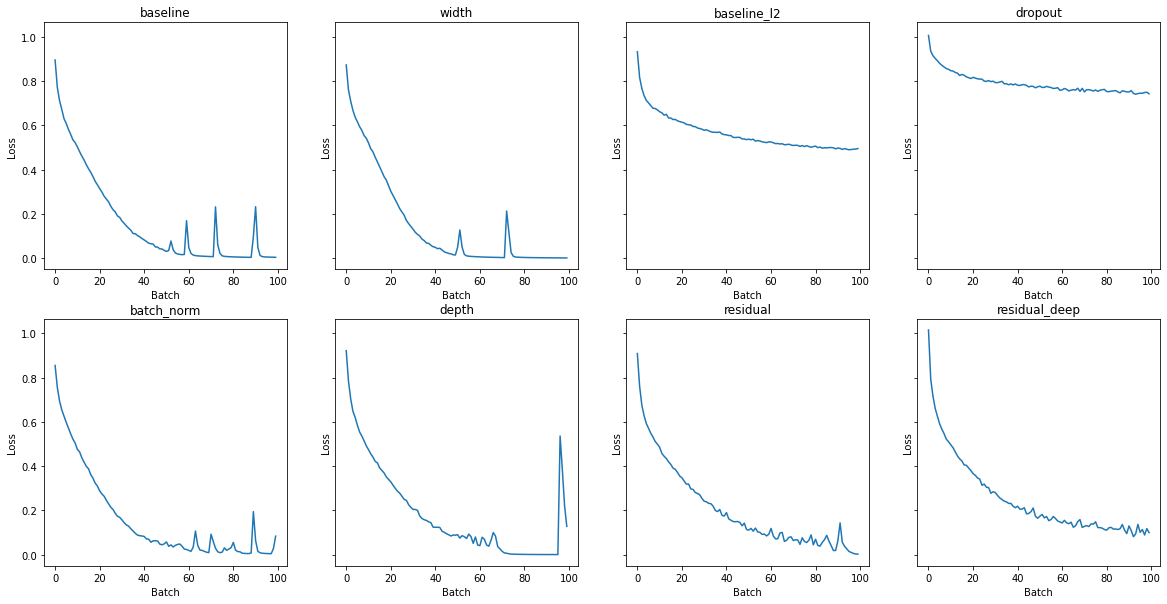

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10), sharey=True)
for i, name in enumerate(models):
  sample = cifar3[np.random.randint(len(cifar3))]
  axs[int(i/4), i%4].plot(models[name]['training_loss'])
  axs[int(i/4), i%4].set_title(name)
  axs[int(i/4), i%4].set_xlabel('Batch')
  axs[int(i/4), i%4].set_ylabel('Loss')

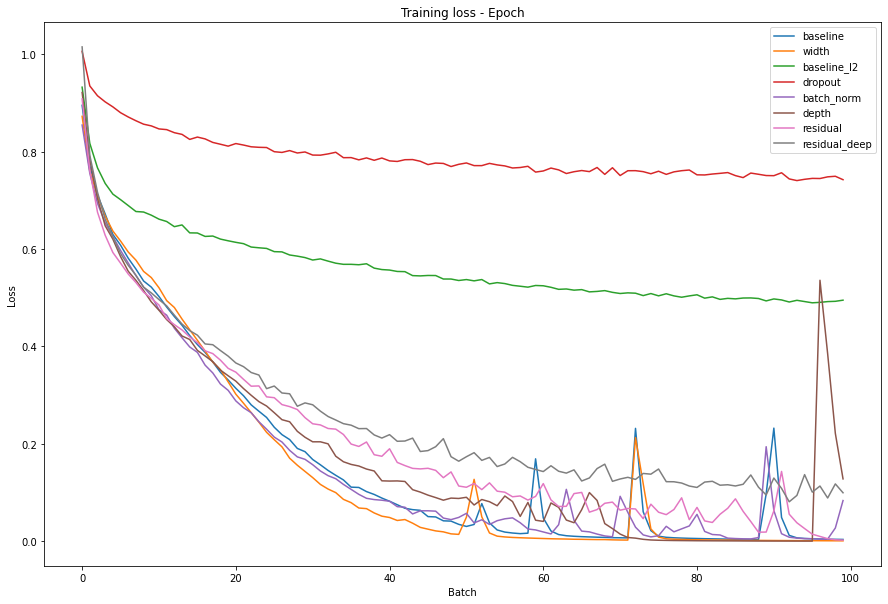

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
for i, name in enumerate(models):
  sample = cifar3[np.random.randint(len(cifar3))]
  ax.plot(models[name]['training_loss'])
  ax.set_title('Training loss - Epoch')
  ax.set_xlabel('Batch')
  ax.set_ylabel('Loss')
ax.legend(models.keys())

### **Accuracy**

These graphs represent the accuracy of each each model in the training and validation dataset.

Text(0, 0.5, 'Accuracy')

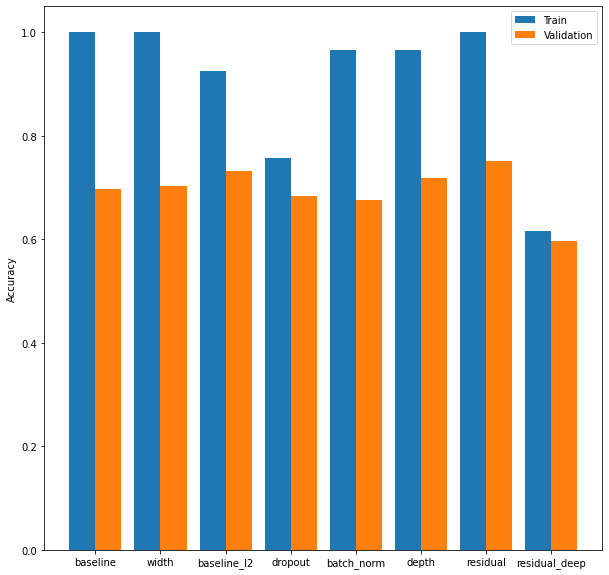

In [28]:
train_acc = [d['train_acc'] for _, d in models.items()]
val_acc = [d['acc'] for _, d in models.items()]

x = np.arange(len(models))
width = 0.4

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(x-width/2, train_acc, width, label='Train')
ax.bar(x+width/2, val_acc, width, label='Validation')

# no idea why I have to add an empty label at the beggining
# but if I dont do it the lables are shifted
ax.set_xticklabels([''] + list(models.keys()))
ax.legend()
ax.set_ylabel('Accuracy')

### **Conclussions**

If we just use the first plots with the training loss we would declare that most of our models behave similarly with Baseline like one of the best architecture we have defined. This is due to the fact that most of our models are quickly overfitting the training dataset.

Dropout and L2 regularization prevent the overfitting, thats why in the plots with the training error, these two architectures keep the error higher than the rest. 

We need to take a look at the performance in the validation dataset, it is this performance the one that is going to tell us if our model is able to generalize enough to work with images that it did not see before. In the bar plot, we can see that the Baseline does not have a specially good performance, the ones that perform the best are the ones with method to stop the overfitting, like the one with L2 regularization, or methods to lern higher level features, like the deep and the residual one.

One special case is the resiald deep architecture, it is strange that it does not overfit the training data, but it is not able to learn the distribution of the data. This architecture may be too big to be trained with this dataset.

The usual way to deal with this is to use not just train a validation datasets but train, validation and test datasets. In this case we would evaluate the model in the validation dataset while we are training the model with the training dataset and we would use the test dataset at the end. That gives us a lot of information about the training process and how much the model is overfitting or underfitting the training dataset.

## **Training Time**

We are going to study the training time using the GPU and the CPU.

We need to retrain the models, this time using the CPU instead the GPU.

In [29]:
device = torch.device('cpu')

n_epochs = 100

for name, d in models.items():
  print(f'Training model {name}')
  # isntatiante the model
  model = d['constructor']()
  # set the l2 reg parameter if the execution has 'l2' in its name
  l2 = 0.002 if 'l2' in name else 0.0

  # optimizer and loss function
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()

  # we are going to time the training process
  t0 = time.time()

  # training
  losses = train(model, train_loader, n_epochs, optimizer, loss_fn, l2)

  # saving the training time in the specific device
  t1 = time.time()
  d['training_time_'+device.type] = t1 - t0
  print(f'Training time was {t1-t0} using device {device.type}')

  # saving the record of losses
  d['training_loss'] = losses

  # saving the trained model
  save_model(model, name)

Training model baseline
2021-03-07 15:28:15.133777 Epoch 0, Training loss 0.8772612751798426
2021-03-07 15:29:22.817782 Epoch 9, Training loss 0.513550178548123
2021-03-07 15:30:30.907804 Epoch 18, Training loss 0.342084432155528
2021-03-07 15:31:37.237504 Epoch 27, Training loss 0.20508500546851058
2021-03-07 15:32:43.493743 Epoch 36, Training loss 0.11078760685755852
2021-03-07 15:33:49.538105 Epoch 45, Training loss 0.05759668064085727
2021-03-07 15:34:55.879172 Epoch 54, Training loss 0.023588695503929828
2021-03-07 15:36:02.272035 Epoch 63, Training loss 0.010059318735085903
2021-03-07 15:37:08.625934 Epoch 72, Training loss 0.200263873012142
2021-03-07 15:38:16.021520 Epoch 81, Training loss 0.004958254216793687
2021-03-07 15:39:23.445088 Epoch 90, Training loss 0.00347268319827445
2021-03-07 15:40:31.090922 Epoch 99, Training loss 0.0036537619728713912
Training time was 743.6872870922089 using device cpu
Training model width
2021-03-07 15:40:38.569974 Epoch 0, Training loss 0.87

Now we are going to plot the results.

Text(0, 0.5, 'Training time')

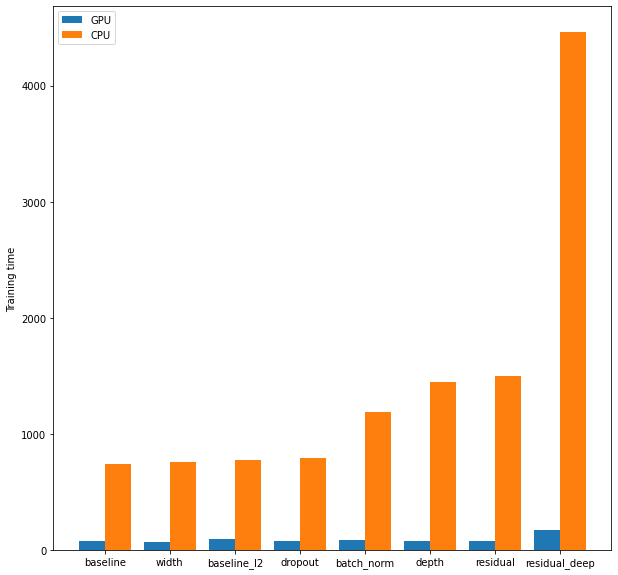

In [31]:
gpu_time = [d['training_time_cuda'] for _, d in models.items()]
cpu_time = [d['training_time_cpu'] for _, d in models.items()]

x = np.arange(len(models))
width = 0.4

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(x-width/2, gpu_time, width, label='GPU')
ax.bar(x+width/2, cpu_time, width, label='CPU')

# no idea why I have to add an empty label at the beggining
# but if I dont do it the lables are shifted
ax.set_xticklabels([''] + list(models.keys()))
ax.legend()
ax.set_ylabel('Training time')

In [42]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model", "GPU training time", "CPU training time", "Relation"]
for name, d in models.items():
  x.add_row([name, d['training_time_cuda'], d['training_time_cpu'], int(d['training_time_cpu']/d['training_time_cuda'])])
print(x)

+---------------+--------------------+--------------------+----------+
|     Model     | GPU training time  | CPU training time  | Relation |
+---------------+--------------------+--------------------+----------+
|    baseline   | 78.98348093032837  | 743.6872870922089  |    9     |
|     width     |  68.3667163848877  | 753.2603261470795  |    11    |
|  baseline_l2  |  92.534095287323   | 777.1682343482971  |    8     |
|    dropout    | 72.31229734420776  | 788.1737356185913  |    10    |
|   batch_norm  | 85.10662031173706  | 1188.4201040267944 |    13    |
|     depth     |  79.5290699005127  | 1447.3321075439453 |    18    |
|    residual   | 80.53588080406189  | 1497.182806968689  |    18    |
| residual_deep | 167.56456112861633 | 4459.316923379898  |    26    |
+---------------+--------------------+--------------------+----------+


From these plots we can see that to train with a GPU is around 10 times faster than to use just the CPU, this is due to the ability to parallelize execution that PyTorch and a GPU bring together.